In [3]:
from graph_tool.generation import *
from graph_tool import GraphView
from graph_tool.correlations import *
from graph_tool.stats import *
from graph_tool.draw import graph_draw, fruchterman_reingold_layout, sfdp_layout, draw_hierarchy
from graph_tool.collection import *
from graph_tool.topology import *
from graph_tool.inference import *
from graph_tool.spectral import *
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [20]:
# number of nodes
N = int(1.00*1e5)

# hospital layer size
fhosp = 0.005
Nhosp = int(fhosp*N)

# health care workers
fhealth = 0.045
Nhealth = int(fhealth*N)

# city layer size
Ncity = N-Nhosp-Nhealth

number nodes 500
number edges 1247


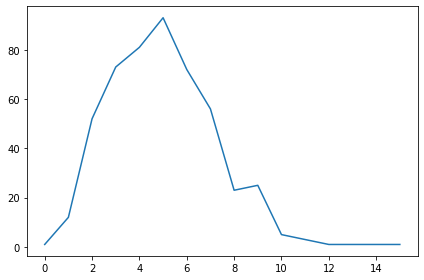

In [21]:
n = Nhosp
p = 5/Nhosp
m = int(p*Nhosp*(Nhosp-1)/2)

print("number nodes", n)
print("number edges", m)

ak = np.floor(2 * m / n)
dm = 2 * m - ak * n

ER = random_graph(n, lambda i: ak + 1 if i < dm else ak, directed=False, random=False) 

ret = random_rewire(ER, 'erdos', n_iter = 1)

degree_hist = vertex_hist(ER, "total")

plt.figure()

plt.plot(degree_hist[1][:-1], degree_hist[0])

plt.tight_layout()

plt.show()

number nodes 4500
number edges 22495


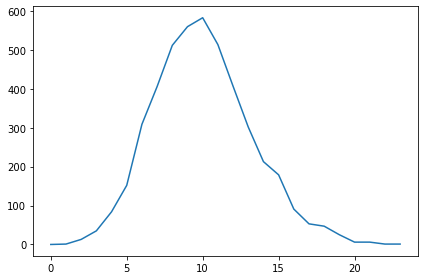

In [22]:
n2 = Nhealth
p2 = 10/Nhealth
m2 = int(p2*Nhealth*(Nhealth-1)/2)

print("number nodes", n2)
print("number edges", m2)

ak2 = np.floor(2 * m2 / n2)
dm2 = 2 * m2 - ak2 * n2

ER2 = random_graph(n2, lambda i: ak2 + 1 if i < dm2 else ak2, directed=False, random=False) 

ret = random_rewire(ER2, 'erdos', n_iter = 1)

degree_hist = vertex_hist(ER2, "total")


plt.figure()

plt.plot(degree_hist[1][:-1], degree_hist[0])

plt.tight_layout()

plt.show()

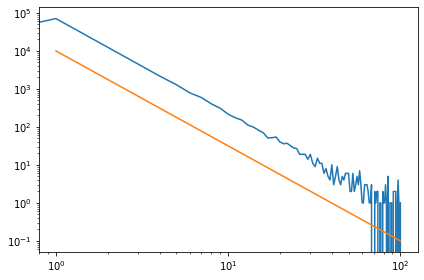

In [23]:
def sample_k(max):

    accept = False

    while not accept:

        k = np.random.randint(1,max+1)

        accept = np.random.random() < 1.0/k**2.5

    return k

SF = random_graph(Ncity, lambda: sample_k(100), directed=False, model = 'configuration', n_iter=100)

degree_hist = vertex_hist(SF, "total")

xx = np.linspace(1, 100)

plt.figure()

plt.plot(degree_hist[1][:-1], degree_hist[0])

plt.plot(xx, 1e4*xx**-2.5)

plt.xscale('log')
plt.yscale('log')

plt.tight_layout()

plt.show()

500


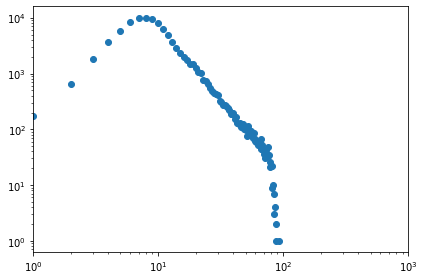

graph size:  98467


In [24]:
# generate SBM

ER_out = ER.get_out_degrees(ER.get_vertices())

ER2_out = ER2.get_out_degrees(ER2.get_vertices())

SF_out = SF.get_out_degrees(SF.get_vertices())

groups = np.asarray(Nhosp*[0]+Nhealth*[1]+Ncity*[2])

in_d = np.append(ER_out,ER2_out)
in_d = np.append(in_d,SF_out)

out_d = np.append(ER_out,ER2_out)
out_d = np.append(out_d,SF_out)

pmatrix = np.asarray([[Nhosp*5,Nhosp*5,0],[Nhosp*5,Nhealth*10,Nhealth*5],[0,Nhealth*5,Ncity*10*np.mean(SF_out)]])

print(Nhosp)
u = generate_sbm(groups, pmatrix, in_degs = in_d, out_degs = out_d, directed = False)

# Extract the largest component
largest_comp = GraphView(u, vfilt = label_largest_component(u))

remove_self_loops(largest_comp)

# remove large degree nodes

remove_list = []
for v in largest_comp.vertices():
    
    if largest_comp.get_total_degrees([v])[0] > 100:
        remove_list.append(v)

largest_comp.remove_vertex(remove_list)

degree_hist = vertex_hist(largest_comp, "total")

#print(degree_hist[1][:-1], degree_hist[0])

plt.figure()

plt.plot(degree_hist[1][:-1], degree_hist[0], 'o')

plt.xscale('log')
plt.yscale('log')
plt.xlim([1,1000])
plt.tight_layout()

plt.show()

A = adjacency(largest_comp)

Mc=A.tocoo()

pre_identifiers = np.asarray(Nhosp*['HOSP']+Nhealth*['HCW']+Ncity*['CITY'])

nodes = sorted(np.unique(Mc.row))
identifier = np.asarray([pre_identifiers[node] for node in nodes])

print("graph size: ", len(Counter(Mc.row).keys()))

np.savetxt('edge_list_SBM_1e5.txt', np.c_[Mc.row,Mc.col], fmt = '%d %d')
np.savetxt('node_identifier_SBM_1e5.txt', np.c_[nodes,identifier], fmt = '%s')


In [23]:
#state = minimize_blockmodel_dl(largest_comp, deg_corr=False)

#state = minimize_nested_blockmodel_dl(largest_comp, deg_corr=True)

#draw_hierarchy(state, output="graph_nested.png")

#v_size=largest_comp.get_out_degrees(largest_comp.get_vertices())

#deg = largest_comp.degree_property_map("out")

#p = fruchterman_reingold_layout(largest_comp, n_iter=1000)

#state.draw(output="graph2.png")

# pos = p, vertex_size = deg,
graph_draw(largest_comp, output="graph.png")


<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f10d05ab850, at 0x7f10d0757820>